In [ ]:
"""
Customer Happiness Analysis Project
---------------------------------
Purpose: Analyze and predict customer happiness from survey responses
Dataset: ACME-HappinessSurvey2020.csv


Features:
X1 = Order delivered on time
X2 = Order contents correct
X3 = Order was easy to make
X4 = Price was fair
X5 = Courier satisfaction
X6 = App easy to use
Y  = Customer happiness (0=unhappy, 1=happy)
"""

# Basic libraries
import pandas as pd
import numpy as np

# Models
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Data processing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def add_interaction_features(df):
    """
    Create interaction features from customer ratings.

    Args:
        df (pd.DataFrame): Original survey dataframe.

    Returns:
        pd.DataFrame: Dataframe with new interaction features added.
    """
    df = df.copy()
    df['service_score'] = df['X1'] * df['X5']  # Delivery × Courier
    df['value_score'] = (df['X2'] * df['X3']) / df['X4']  # Quality/Price
    df['experience_score'] = df['X5'] * df['X6']  # Courier × App
    return df

def add_threshold_features(df):
    """
    Create binary features for high/low satisfaction thresholds.

    Args:
        df (pd.DataFrame): Original survey dataframe.

    Returns:
        pd.DataFrame: Dataframe with new threshold features added.
    """
    df = df.copy()
    df['high_delivery'] = (df['X1'] >= 4).astype(int)
    df['high_value'] = ((df['X2'] >= 4) & (df['X3'] >= 4)).astype(int)
    df['high_service'] = ((df['X5'] >= 4) & (df['X6'] >= 4)).astype(int)
    df['delivery_issues'] = (df['X1'] <= 2).astype(int)
    df['value_issues'] = (df['X4'] >= 4).astype(int)
    return df

def add_aggregate_features(df):
    """
    Create aggregate features from customer ratings.

    Args:
        df (pd.DataFrame): Original survey dataframe.

    Returns:
        pd.DataFrame: Dataframe with new aggregate features added.
    """
    df = df.copy()
    df['avg_rating'] = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']].mean(axis=1)
    df['high_ratings_count'] = (df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']] >= 4).sum(axis=1)
    df['low_ratings_count'] = (df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6']] <= 2).sum(axis=1)
    return df

In [ ]:
def perform_basic_eda(df):
    """
    Perform basic exploratory data analysis on survey data.

    Args:
        df (pd.DataFrame): Customer survey dataframe.

    Returns:
        None: Displays visualizations and prints statistics.
    """
    print("\nData Overview:")
    print("Shape:", df.shape)
    print("\nClass distribution:")
    print(df['Y'].value_counts(normalize=True))

    plt.figure(figsize=(15, 5))

    # Correlation plot
    plt.subplot(1, 3, 1)
    correlation_matrix = df[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'Y']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlations')

    # Target distribution
    plt.subplot(1, 3, 2)
    sns.countplot(data=df, x='Y')
    plt.title('Customer Happiness Distribution')

    # Features by target
    plt.subplot(1, 3, 3)
    df_melted = df.melt(id_vars=['Y'], value_vars=['X1', 'X2', 'X3', 'X4', 'X5', 'X6'])
    sns.boxplot(data=df_melted, x='variable', y='value', hue='Y')
    plt.title('Ratings by Customer Happiness')
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_observed(X_test, y_test, predictions, feature_name):
    """
    Plot predictions vs observed values with observation counts.

    Args:
        X_test: Feature values
        y_test: Actual values
        predictions: Model predictions
        feature_name: Name of feature being plotted

    Returns:
        None: Displays plot with two lines and bars
    """
    plt.figure(figsize=(10, 6))

    # Get feature values
    x_values = X_test[feature_name]

    # Calculate averages
    df_analysis = pd.DataFrame({
        'x': x_values,
        'observed': y_test,
        'predicted': np.mean([pred for pred in predictions.values()], axis=0)
    })

    # Calculate means for each x value
    observed_means = df_analysis.groupby('x')['observed'].mean()
    predicted_means = df_analysis.groupby('x')['predicted'].mean()
    counts = df_analysis['x'].value_counts().sort_index()

    # Create plot
    plt.bar(counts.index, counts.values, alpha=0.3, color='gray', label='Observation Count')
    plt.plot(observed_means.index, observed_means.values, 'b-', label='Observed Average')
    plt.plot(predicted_means.index, predicted_means.values, 'r--', label='Predicted Average')

    plt.title(f'Predictions vs Observed Values - {feature_name}')
    plt.xlabel('Feature Value')
    plt.ylabel('Average / Count')
    plt.legend()
    plt.show()

def plot_confusion_matrices(y_test, predictions):
    """
    Create confusion matrices for model evaluation.

    Args:
        y_test: Actual values
        predictions: Dictionary of model predictions

    Returns:
        None: Displays confusion matrices
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for idx, (name, y_pred) in enumerate(predictions.items()):
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', ax=axes[idx], cmap='Blues')
        axes[idx].set_title(f'{name} Confusion Matrix')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

Saving ACME-HappinessSurvey2020.csv to ACME-HappinessSurvey2020 (2).csv

Data Overview:
Shape: (126, 7)

Class distribution:
Y
1    0.547619
0    0.452381
Name: proportion, dtype: float64


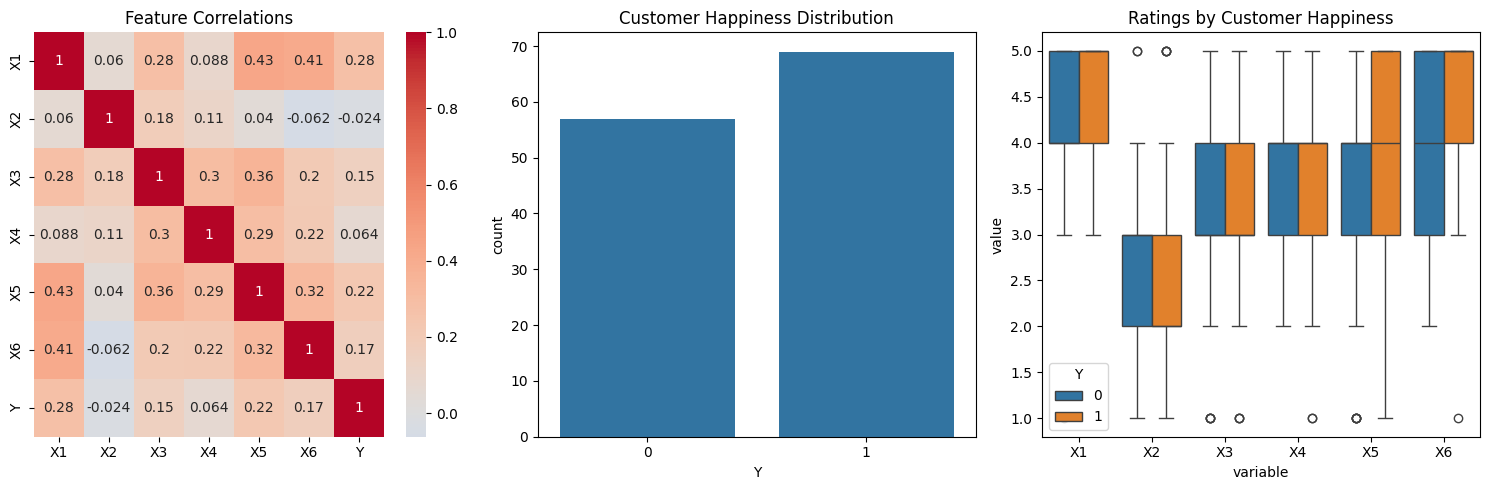

In [ ]:
# Load data
from google.colab import files
uploaded = files.upload()
df = pd.read_csv('ACME-HappinessSurvey2020.csv')

# Add engineered features
df_engineered = df.copy()
df_engineered = add_interaction_features(df_engineered)
df_engineered = add_threshold_features(df_engineered)
df_engineered = add_aggregate_features(df_engineered)

# Perform initial EDA
perform_basic_eda(df)

In [ ]:
# Define features
base_features = ['X1', 'X2', 'X3', 'X4', 'X5', 'X6']
all_features = base_features + [
    'service_score', 'value_score', 'experience_score',
    'high_delivery', 'high_value', 'high_service',
    'delivery_issues', 'value_issues',
    'avg_rating', 'high_ratings_count', 'low_ratings_count'
]

# Prepare data
X = df_engineered[all_features]
y = df_engineered['Y']

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=4, min_samples_split=5, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42),
    'XGBoost': XGBClassifier(max_depth=4, learning_rate=0.05, n_estimators=200, random_state=42)
}

# Train and evaluate models
predictions = {}
for name, model in models.items():
    # Train model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred

    # Print results
    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))


Decision Tree Results:
Accuracy: 0.538

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        15
           1       0.47      0.73      0.57        11

    accuracy                           0.54        26
   macro avg       0.57      0.56      0.54        26
weighted avg       0.58      0.54      0.53        26


Random Forest Results:
Accuracy: 0.538

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.33      0.45        15
           1       0.47      0.82      0.60        11

    accuracy                           0.54        26
   macro avg       0.59      0.58      0.53        26
weighted avg       0.61      0.54      0.52        26


XGBoost Results:
Accuracy: 0.654

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.60      0.67        15
           1       0.57      0.73      0.64        

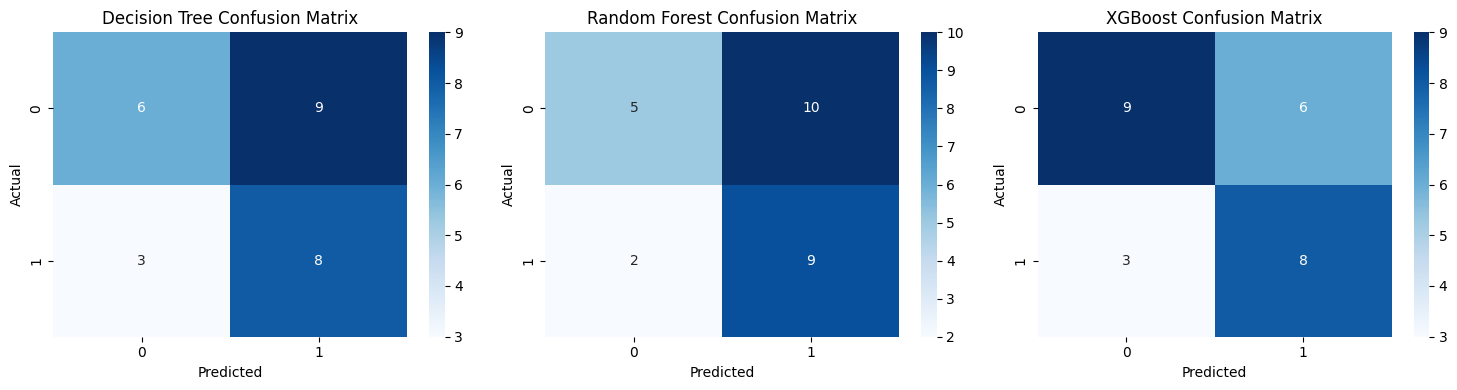

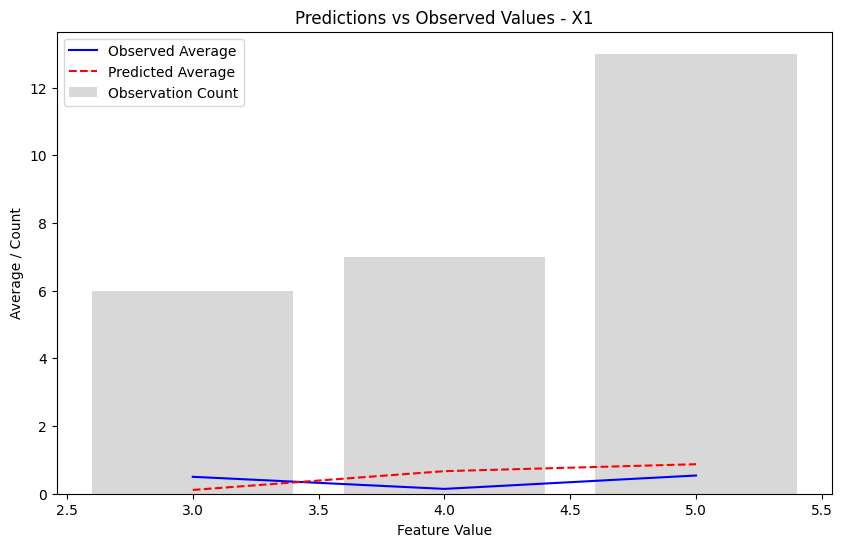

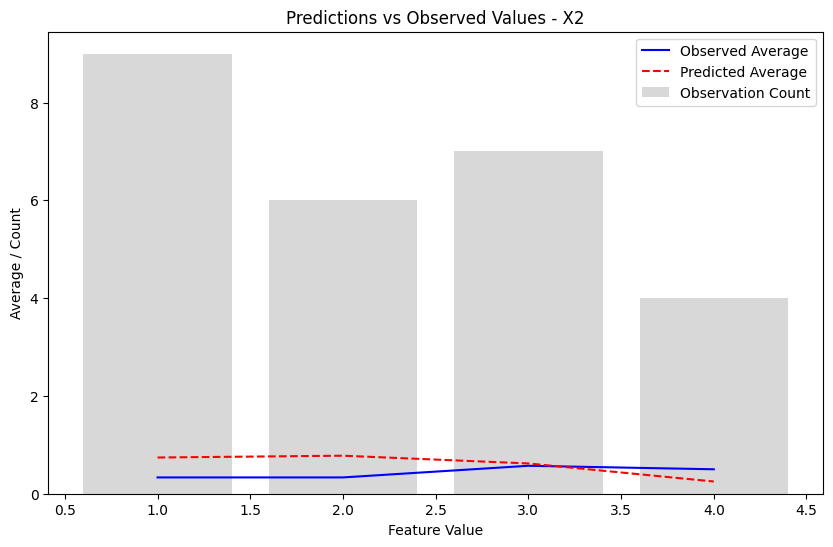

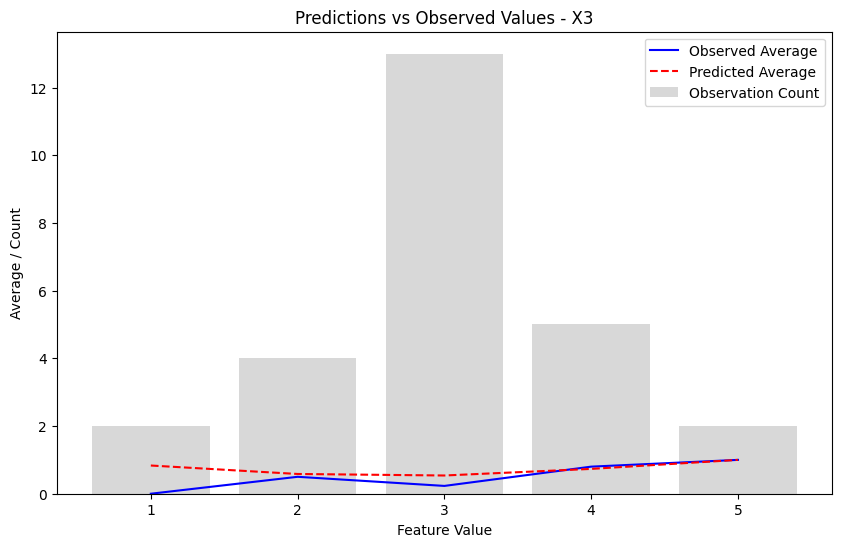

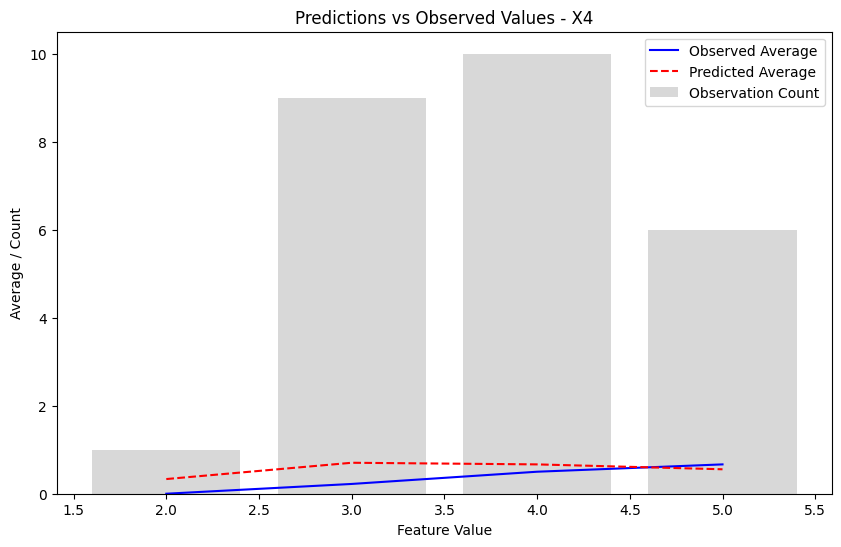

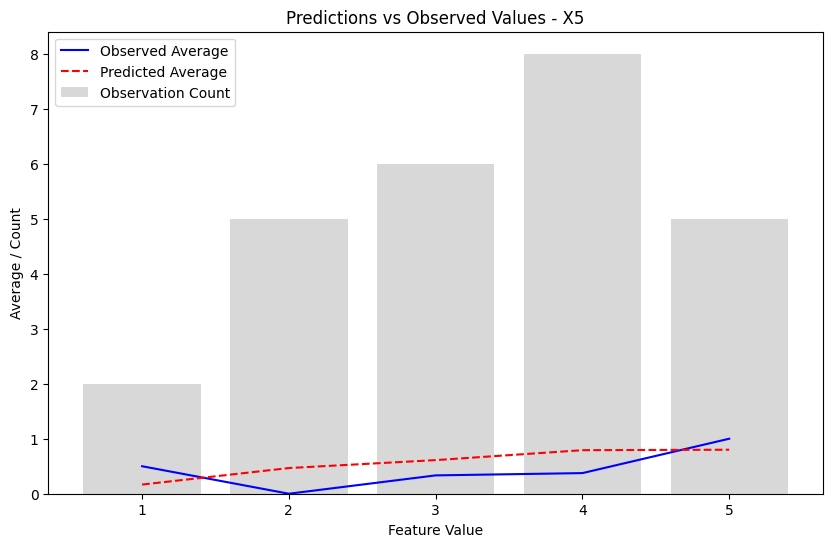

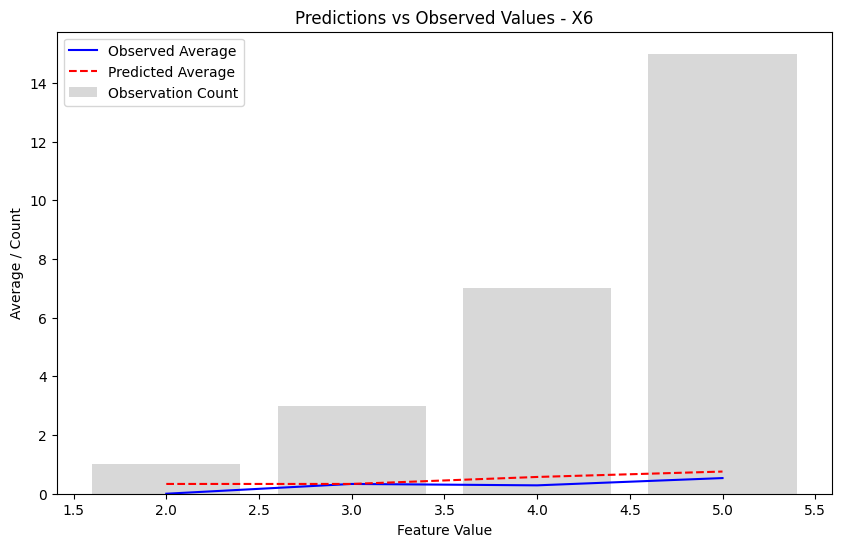

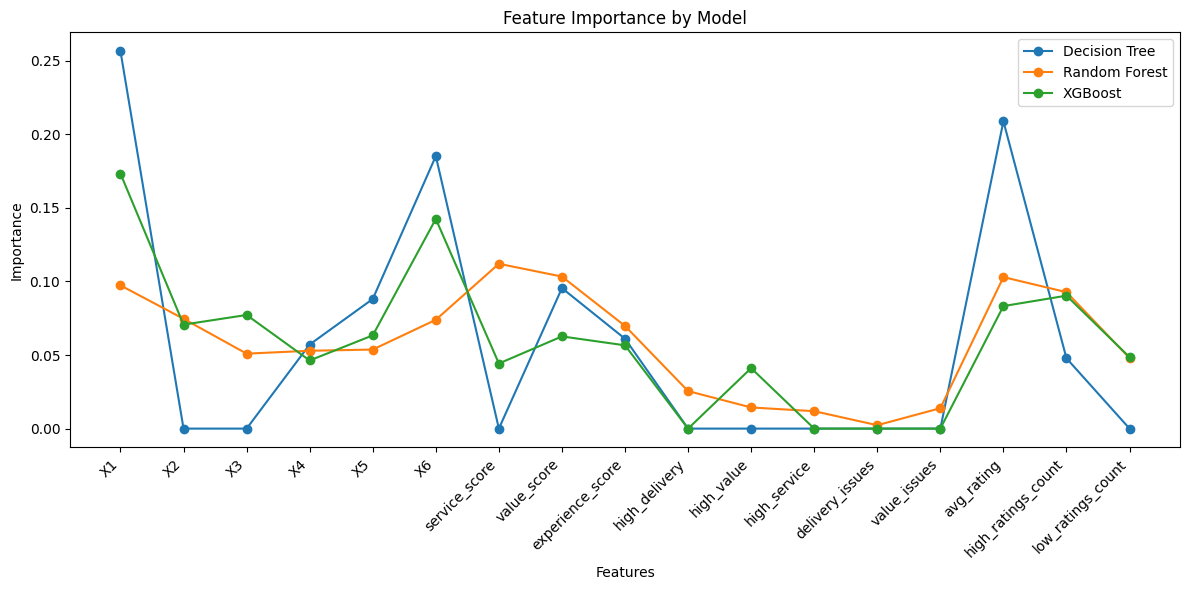


Model Performance Summary:
Decision Tree Accuracy: 0.538
Random Forest Accuracy: 0.538
XGBoost Accuracy: 0.654


In [ ]:
# Plot confusion matrices
plot_confusion_matrices(y_test, predictions)

# Plot predictions vs observed for each base feature
for feature in base_features:
    plot_predictions_vs_observed(
        X_test=X_test,
        y_test=y_test,
        predictions=predictions,
        feature_name=feature
    )

# Plot feature importance
plt.figure(figsize=(12, 6))
for name, model in models.items():
    plt.plot(all_features, model.feature_importances_, 'o-', label=name)
plt.title('Feature Importance by Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Print final summary
print("\nModel Performance Summary:")
for name, pred in predictions.items():
    print(f"{name} Accuracy: {accuracy_score(y_test, pred):.3f}")